<a href="https://colab.research.google.com/github/rupesh-mr/sionna/blob/main/Autoencoder_Sionna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sionna

In [ ]:
!pip install --upgrade --force-reinstall pandas h5py spacy

In [14]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense,Lambda,BatchNormalization
from keras.models import Model
from keras.optimizers import Adam

In [15]:
N = 10000
M=16
n_channel=7
indices = np.random.randint(M,size=N)
data = tf.one_hot(indices, M)

In [16]:
data.shape

TensorShape([10000, 16])

In [17]:
from tensorflow.keras.layers import Layer

In [18]:
import sionna

In [33]:
from sionna.phy.channel import AWGN
from sionna.phy.utils import ebnodb2no

# --- Parameters ---
M = 16                      # Number of messages
n_channel = 7               # Channel uses per message
k = int(np.log2(M))         # Bits per message = log2(16) = 4
R = k / n_channel           # Code rate
ebno_db = 7.0               # Eb/N0 in dB


no = ebnodb2no(ebno_db, k, R)
no = tf.constant(no, dtype=tf.float32)

class Real2ComplexLike(Layer):
    def call(self, x):
        return tf.complex(x, tf.zeros_like(x))
    def compute_output_shape(self, input_shape):
        return input_shape

class Awgn(Layer):
    def __init__(self, no):
        super().__init__()
        self.no = no
        self.awgn = AWGN()

    def call(self, x):
        return self.awgn(x, self.no)

    def compute_output_shape(self, input_shape):
        return input_shape

class RealPart(Layer):
    def call(self, x):
        return tf.cast(tf.math.real(x), tf.float32)
    def compute_output_shape(self, input_shape):
        return input_shape
class FixedPowerNormalization(Layer):
    def __init__(self, target_energy=1.0, eps=1e-12, **kwargs):
        super().__init__(**kwargs)
        self.target_energy = target_energy
        self.eps = eps

    def call(self, x):

        power = tf.reduce_sum(tf.square(x), axis=-1, keepdims=True)
        target_energy = tf.cast(self.target_energy, x.dtype)
        eps = tf.cast(self.eps, x.dtype)
        denom = tf.sqrt(tf.maximum(power, eps))
        scale = tf.sqrt(target_energy) / denom
        return x * scale

class AveragePowerNormalization(Layer):
    def __init__(self, target_energy=1.0, eps=1e-12, **kwargs):
        super().__init__(**kwargs)
        self.target_energy = target_energy
        self.eps = eps

    def call(self, x):
        batch_power = tf.reduce_mean(tf.reduce_sum(tf.square(x), axis=1))  # scalar
        scale = tf.sqrt(self.target_energy / (batch_power + self.eps))
        return x * scale

class Autoencoder(tf.keras.Model):
    def __init__(self, M, n_channel, noise_power):
        super(Autoencoder, self).__init__()
        self.M = M
        self.n_channel = n_channel
        self.noise_power = noise_power
        self.encoder = tf.keras.Sequential([
            Dense(M, activation='relu'),
            Dense(n_channel, activation='linear'),
            FixedPowerNormalization(target_energy=n_channel),
            #AveragePowerNormalization(target_energy=n_channel),
            Real2ComplexLike()
        ])
        self.channel = Awgn(noise_power)
        self.decoder = tf.keras.Sequential([
            Dense(M, activation='relu'),
            Dense(M, activation='softmax')
        ])

    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.channel(x)
        x = RealPart()(x)
        x = self.decoder(x)
        return x


autoencoder = Autoencoder(M=M, n_channel=n_channel, noise_power=no)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy')

In [34]:
N_val = 1500
val_labels = np.random.randint(M,size=N_val)
val_data=tf.one_hot(val_labels, M)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.8347 - val_loss: 2.4045
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2857 - val_loss: 1.9493
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8403 - val_loss: 1.5107
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4165 - val_loss: 1.1588
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0723 - val_loss: 0.8672
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8019 - val_loss: 0.6395
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5910 - val_loss: 0.4684
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4361 - val_loss: 0.3497
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3283 - val_loss: 0.2627
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2453 - val_loss: 0.2028
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1923 - val_loss: 0.1616
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1527 - val_lo

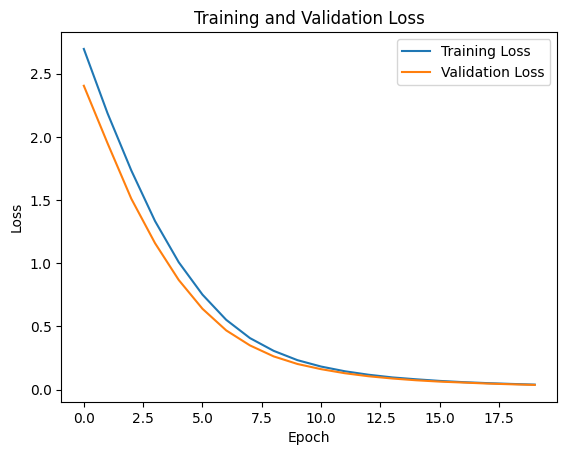

In [35]:
import matplotlib.pyplot as plt
NUM_EPOCHS = 20 #We might have to increase number of epochs for getting better constellation points
BATCH_SIZE = 300

history = autoencoder.fit(data, data, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_data, val_data))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#We can use a scatter plot to visualise constellation when n_channel=2
import matplotlib.pyplot as plt

encoded = autoencoder.encoder(val_data)
noisy = autoencoder.channel(encoded)
noisy_real = tf.math.real(noisy).numpy()
plt.scatter(noisy_real[:, 0], noisy_real[:, 1], cmap='viridis')
plt.title('Scatter Plot of Noisy Data')
plt.show()

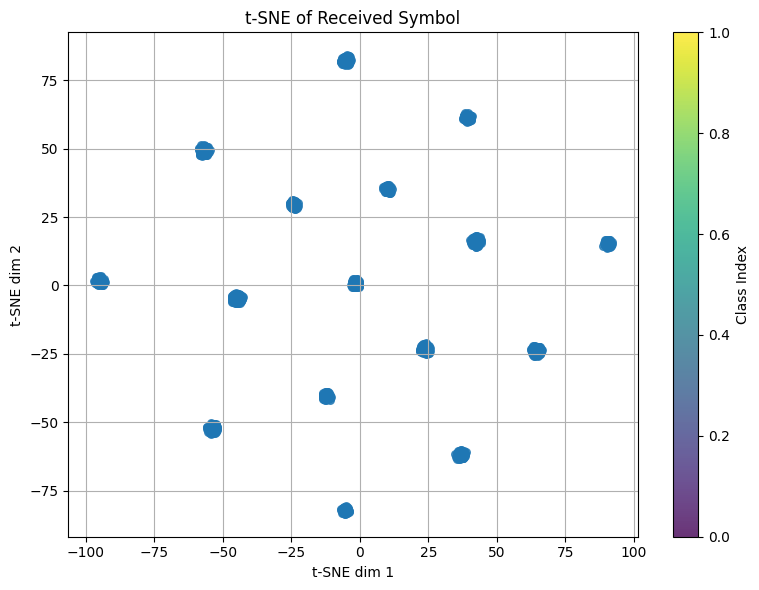

In [36]:
#We can use t-SNE when n_channel>2
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
encoded = autoencoder.encoder(val_data)
noisy = autoencoder.channel(encoded)

noisy_real = tf.math.real(noisy).numpy()

tsne = TSNE(learning_rate=700, n_components=2,max_iter=35000, random_state=0, perplexity=60)
tsne_result = tsne.fit_transform(noisy_real)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1],
                      s=30, alpha=0.8)
plt.title("t-SNE of Received Symbol")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.grid(True)
plt.colorbar(scatter, label='Class Index')
plt.tight_layout()
plt.show()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -4.0 | 7.0000e-02 | 1.4222e-01 |         252 |        3600 |          128 |         900 |         0.1 |reached target block errors
     -3.5 | 5.5417e-02 | 1.0833e-01 |         266 |        4800 |          130 |        1200 |         0.1 |reached target block errors
     -3.0 | 3.8167e-02 | 7.3333e-02 |         229 |        6000 |          110 |        1500 |         0.1 |reached target block errors
     -2.5 | 2.4405e-02 | 4.7619e-02 |         205 |        8400 |          100 |        2100 |         0.2 |reached target block errors
     -2.0 | 2.2292e-02 | 4.4583e-02 |         214 |        9600 |          107 |        2400 |         0.2 |reached target block errors
     -1.5 | 1.5606e-02 | 3.0303e-02 |         206 |       13200 |

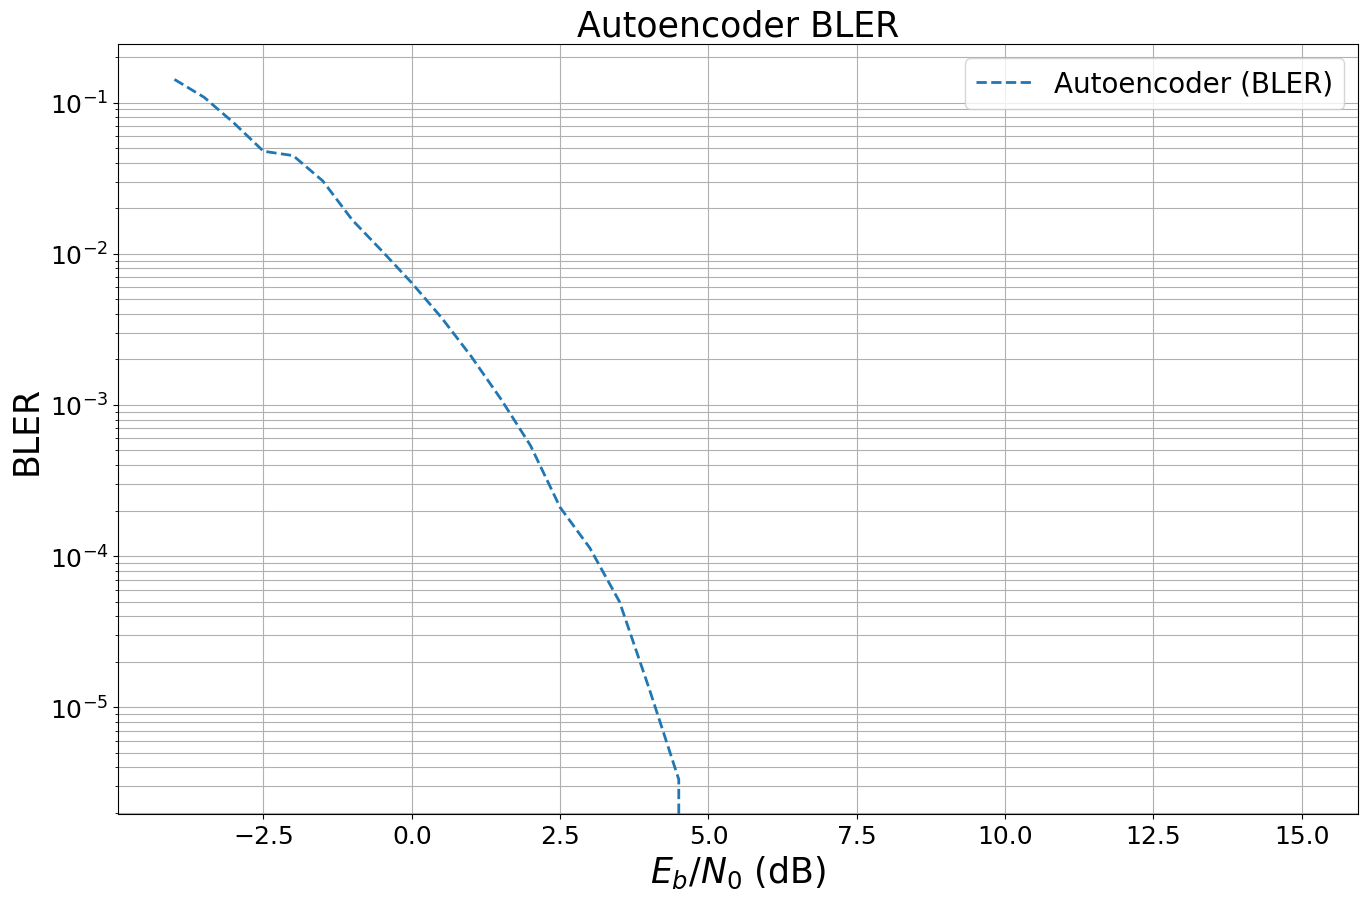

In [37]:
def int_to_bits(int_array, n_bits=4):
    return ((int_array[:, None] & (1 << np.arange(n_bits)[::-1])) > 0).astype(np.uint8)

def mc_fun(batch_size, ebno_db):
    symbols = np.random.randint(0, M, size=batch_size)
    x = tf.one_hot(symbols, depth=M)
    no = ebnodb2no(ebno_db, k, R)
    no = tf.constant(no , dtype=tf.float32)
    autoencoder.channel.no = no
    y_hat = autoencoder(x, training=False)
    pred = np.argmax(y_hat, axis=1)
    b_true = int_to_bits(symbols,n_bits=k)
    b_pred = int_to_bits(pred,n_bits=k)
    return b_true, b_pred

EbNodB_range = np.arange(-4, 15.5, 0.5)
bler_plot = sionna.phy.utils.PlotBER("Autoencoder BLER")
bler_plot.simulate(
    mc_fun,
    ebno_dbs=EbNodB_range,
    batch_size=300,
    num_target_block_errors=100,
    legend="Autoencoder",
    soft_estimates=False,
    max_mc_iter=1000,
    show_fig=True,
    add_bler=True,
    add_ber=False);